## Load packages and libraries.

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from _loadlib.pru0506 import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load objects

In [3]:
adata_raw_pru = sc.read_h5ad(filename=output_dir+'../Data/pru/adata_raw.h5ad')
adata_allg_pru = sc.read_h5ad(filename=output_dir+'../Data/pru/adata_allg.h5ad')
adata_scv_pru = sc.read_h5ad(filename=output_dir+'../Data/pru/adata_sc_velocyto.h5ad')
entire_df_pru = pd.DataFrame(adata_allg_pru.X.A, index=adata_allg_pru.obs.index,
                         columns=adata_allg_pru.var.index).astype(float)
gpd = {x:y for x,y in zip(adata_allg_pru.var.index.values,
                          adata_allg_pru.var['product'].values)}
adata_allg_rh = sc.read_h5ad(filename=output_dir+'../Data/0701+0702/adata_allg.h5ad')
gpd_rh = {x:y for x,y in zip(adata_allg_rh.var.index.values,
                          adata_allg_rh.var['product'].values)}
cc_cdict = {y:cell_cycle_cmap(x) for x, y in
            enumerate(np.unique(adata_scv_pru.obs['cell_cycle'].values))}

## Generate figures

### Figure 1 SFig 1c

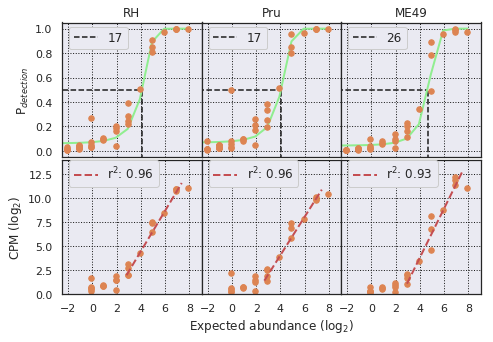

In [3]:
def fig1_sfig1_sensitivity(X, ercc_amount):
    clf, halfmax = sat.quantify_sensitivity(ercc_amount,
                                            expression_mat=X,
                                            minimum_ercc_amount=0.1,
                                            min_expression=2)
    pdet = np.greater(X[ercc_amount.index], 2).sum(axis=0) / X.shape[0]
    plot_y = sat.logistic_model(ercc_amount.values, clf.coef_,
                                clf.intercept_).ravel()
    order = np.argsort(ercc_amount.values)
    x = np.log2(ercc_amount.values)[order]
    y = plot_y[order]
    pdet = pdet[order]
    return (x, y, pdet, halfmax)

def fig1_sfig1_accuracy(X, m, b, curr, ercc_amount):
    test_x = np.linspace(np.min(X), np.max(X+.5), 50).reshape(-1, 1)
    pred_y = (test_x*m + b)
    fitted = sat.quantify_transcripts(curr)
    expected_amount = np.log2(ercc_amount)
    observed_amount = curr[ercc_amount.index.values].mean(axis=0)
    observed_amount = observed_amount.loc[expected_amount > -1]
    expected_amount = expected_amount.loc[expected_amount > -1]
    return (test_x, pred_y, expected_amount, observed_amount)

dirs = [output_dir+'../Data/0701+0702/', output_dir+'../Data/pru/',
        output_dir+'../Data/011_me49/']
titles = ['RH', 'Pru', 'ME49']
ercc_amount = sat.get_ercc_amount()
ercc_amount = ercc_amount.loc[np.setdiff1d(ercc_amount.index.values,
                                           ['ERCC-00060'])]
fig, axs =  plt.subplots(figsize=(2.5*3, 2.5*2), ncols=3, nrows=2)
fig.subplots_adjust(wspace=0, hspace=0.02)
axs = axs.flatten()
for i, ax in enumerate(axs[:3]):
    ad_norm = sc.read_h5ad(dirs[i]+'adata_allg.h5ad')
    keep_cells = ad_norm.obs_names
    ad = sc.read_h5ad(dirs[i]+'adata_raw.h5ad')[keep_cells]
    curr = pd.DataFrame(np.log2(ad.X.A+1), index=ad.obs_names,
                        columns=ad.var_names)
    x, y, pdet, halfmax = fig1_sfig1_sensitivity(curr, ercc_amount)
    ax.scatter(x, pdet, s=30, c='C1', zorder=10)
    ax.set_xlim(-2.5, 9)
    ax.set_xticks([-2, 0, 2, 4, 6, 8])
    ax.set_xticklabels([])
    ax.set_ylim(-0.05, 1.05);
    ax.set_yticks(np.linspace(0, 1, 6))
    if i != 0:
        ax.set_yticklabels([])
    ax.grid(True, ls=':', c='k')
    ax.set_title(titles[i], fontsize=12);
    ax.plot([-10, np.log2(halfmax)], np.repeat(0.5, 2), ls='--', c='k',
            label = r'%s' %(str(int(np.round(halfmax, 0)))))
    ax.plot(np.repeat(np.log2(halfmax), 2) , [-5, 0.5], ls='--', c='k')
    ax.plot(x, y, c='lightgreen', lw=2)
    ax.legend(loc=(0.05, 0.8), fontsize=12, frameon=True, framealpha=1)
    ax = axs[i + 3]
    above_dl = ercc_amount.index.values[ercc_amount > 5]
    curr = pd.DataFrame(np.log2(ad_norm.X.A+1), index=ad.obs_names,
                        columns=ad.var_names)
    ground_truth = np.log2(ercc_amount.loc[above_dl]+1)
    X, y, (m, b, r2) = sat.linreg_fit(curr[above_dl], ground_truth)
    test_x, pred_y, expected_amount, observed_amount =\
            fig1_sfig1_accuracy(X, m, b, curr, ercc_amount)
    ax.scatter(expected_amount, observed_amount, s=30, color='C1')
    ax.plot(pred_y, test_x.flatten(), c='r', linestyle='--', lw=2,
            label=r'r$^2$: {:}'.format(str(np.round(r2, 2))))
    ax.set_xlim(-2.5, 9);
    ax.set_xticks([-2, 0, 2, 4, 6, 8])
    ax.set_ylim(0, 14)
    if i != 0:
        ax.set_yticklabels([])
    ax.grid(True, ls=':', c='k')
    ax.legend(loc=(0.05, 0.80), fontsize=12, frameon=True, framealpha=1)
axs[0].set_ylabel(r'P$_{detection}$', fontsize=12)
axs[0+3].set_ylabel(r'CPM (log$_{2}$)')
axs[1+3].set_xlabel(r'Expected abundance (log$_{2}$)')
fig.savefig(output_dir+'fig1_sfig1c_sensitivity_accuracy.pdf',
        bbox_inches='tight', transparent=True)

### Figure 1 SFig 2
### Cell filter plots

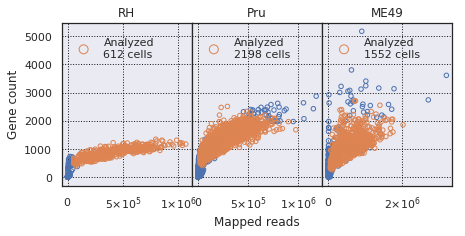

In [4]:
pru_adata = sc.read_h5ad(output_dir+'../Data/pru/adata_allg.h5ad')
pru_adata_raw = sc.read_h5ad(output_dir+'../Data/pru/adata_raw.h5ad')
rh_adata = sc.read_h5ad(output_dir+'../Data/0701+0702/adata_allg.h5ad')
rh_adata_raw = sc.read_h5ad(output_dir+'../Data/0701+0702/adata_raw.h5ad')
me49_adata = sc.read_h5ad(output_dir+'../Data/011_me49/adata_allg.h5ad')
me49_adata_raw = sc.read_h5ad(output_dir+'../Data/011_me49/adata_raw.h5ad')

fig, axs = plt.subplots(figsize=(7,3), ncols=3, sharey=True)
fig.subplots_adjust(wspace=0)
X = rh_adata_raw
subset = rh_adata.obs_names
rs_bad = (X[np.setdiff1d(X.obs_names, subset)].X.A.sum(axis=1))
gc_bad = np.greater(X[np.setdiff1d(X.obs_names, subset)].X.A, 1).sum(axis=1)
rs_f = (X[subset].X.A.sum(axis=1))
gc_f = np.greater(X[subset].X.A, 1).sum(axis=1)
axs[0].scatter(rs_bad, gc_bad, c='', edgecolor='C0', s=20);
axs[0].scatter(rs_f, gc_f, c='', edgecolor='C1', s=20,
               label='Analyzed\n%s cells' %(len(subset)));
axs[0].set_title('RH');
X = pru_adata_raw
subset = pru_adata.obs_names
rs_bad = (X[np.setdiff1d(X.obs_names, subset)].X.A.sum(axis=1))
gc_bad = np.greater(X[np.setdiff1d(X.obs_names, subset)].X.A, 1).sum(axis=1)
rs_f = (X[subset].X.A.sum(axis=1))
gc_f = np.greater(X[subset].X.A, 1).sum(axis=1)
axs[1].scatter(rs_bad, gc_bad, c='', edgecolor='C0', s=20)
axs[1].scatter(rs_f, gc_f, c='', edgecolor='C1', s=20,
               label='Analyzed\n%s cells' %(len(subset)));
axs[1].set_title('Pru');
X = me49_adata_raw
subset = me49_adata.obs_names
rs_bad = (X[np.setdiff1d(X.obs_names, subset)].X.A.sum(axis=1))
gc_bad = np.greater(X[np.setdiff1d(X.obs_names, subset)].X.A, 1).sum(axis=1)
rs_f = (X[subset].X.A.sum(axis=1))
gc_f = np.greater(X[subset].X.A, 1).sum(axis=1)
axs[2].scatter(rs_bad, gc_bad, c='', edgecolor='C0', s=20)
axs[2].scatter(rs_f, gc_f, c='', edgecolor='C1', s=20,
               label='Analyzed\n%s cells' %(len(subset)));
axs[2].set_title('ME49');
axs[1].set_xlabel(r'Mapped reads')
axs[0].set_ylabel(r'Gene count')
for ax in axs:
    ax.legend(loc=(0.05, 0.75), frameon=False, markerscale=2)
import matplotlib.ticker as mticker
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
for ax in axs:
    ax.xaxis.set_major_formatter(sat.plot.MathTextSciFormatter("%1.0e"))
    ax.grid(True, ls=':', color='k')
fig.savefig(output_dir+'fig1_sfig1_cell_filter_allSamples.pdf',\
            bbox_inches='tight', transparent=True)

### Figure 1 SFig 2

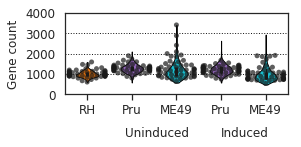

In [5]:
## figure 1e
rh_adata = sc.read_h5ad(output_dir+'../Data/0701+0702/adata_filtered.h5ad')
me49_adata = sc.read_h5ad(output_dir+'../Data/011_me49/adata_filtered.h5ad')
pru_adata = sc.read_h5ad(output_dir+'../Data/pru/adata_filtered.h5ad')
values = []
labels = []
values.append(rh_adata.obs['gene_count'].values)
labels.append('RH')
values.append(pru_adata.obs['gene_count'][pru_adata.obs['dpi'] == 'Day 0'])
labels.append('Pru')
values.append(me49_adata.obs['gene_count'][me49_adata.obs['dpi'] == 'Day 0'])
labels.append('ME49')
values.append(pru_adata.obs['gene_count'][pru_adata.obs['dpi'] != 'Day 0'])
labels.append('Pru')
values.append(me49_adata.obs['gene_count'][me49_adata.obs['dpi'] != 'Day 0'])
labels.append('ME49')
plot = sat.plot.violin(values, labels=labels, c=[0.1, 0.4, 0.9, .4, .9], cmap='tab20',\
                       run=False, figsize=(4, 1.5),\
                       ylabel='Gene count', sina=True, vert=True);
fig, ax = plot.run()
ax.text(0.27, -0.52, 'Uninduced', transform=ax.transAxes, fontsize=12);
ax.text(0.7, -0.52, 'Induced', transform=ax.transAxes, fontsize=12);
ax.set_yticks([0, 1000, 2000, 3000, 4000])
ax.grid(True, ls=':', color='k', axis='y')
fig.savefig(output_dir+'fig1_sfig2b_gc_all_samples.pdf', bbox_inches='tight', transparent=True);

### Figure 1 SFig 2

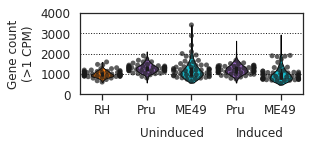

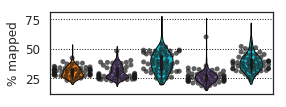

In [6]:
rh_adata = sc.read_h5ad(output_dir+'../Data/0701+0702/adata_filtered.h5ad')
me49_adata = sc.read_h5ad(output_dir+'../Data/011_me49/adata_filtered.h5ad')
pru_adata = sc.read_h5ad(output_dir+'../Data/pru/adata_filtered.h5ad')
values = []
labels = []
values.append(rh_adata.obs['gene_count'].values)
labels.append('RH')
values.append(pru_adata.obs['gene_count'][pru_adata.obs['dpi'] == 'Day 0'])
labels.append('Pru')
values.append(me49_adata.obs['gene_count'][me49_adata.obs['dpi'] == 'Day 0'])
labels.append('ME49')
values.append(pru_adata.obs['gene_count'][pru_adata.obs['dpi'] != 'Day 0'])
labels.append('Pru')
values.append(me49_adata.obs['gene_count'][me49_adata.obs['dpi'] != 'Day 0'])
labels.append('ME49')
plot = sat.plot.violin(values, labels=labels, c=[0.1, 0.4, 0.9, .4, .9], cmap='tab20',\
                       run=False, figsize=(4, 1.5),\
                       ylabel='Gene count\n(>1 CPM)', sina=True, vert=True);
fig, ax = plot.run()
ax.text(0.27, -0.52, 'Uninduced', transform=ax.transAxes, fontsize=12);
ax.text(0.7, -0.52, 'Induced', transform=ax.transAxes, fontsize=12);
ax.set_yticks([0, 1000, 2000, 3000, 4000])
ax.grid(True, ls=':', color='k', axis='y')
fig.savefig(output_dir+'gc_all_samples.pdf', bbox_inches='tight', transparent=True);
values = []
labels = []
values.append(rh_adata.obs['percent_mapped'].values)
labels.append('RH')
values.append(pru_adata.obs['percent_mapped'][pru_adata.obs['dpi'] == 'Day 0'])
labels.append('Pru')
values.append(me49_adata.obs['percent_mapped'][me49_adata.obs['dpi'] == 'Day 0'])
labels.append('ME49')
values.append(pru_adata.obs['percent_mapped'][pru_adata.obs['dpi'] != 'Day 0'])
labels.append('Pru')
values.append(me49_adata.obs['percent_mapped'][me49_adata.obs['dpi'] != 'Day 0'])
labels.append('ME49')
plot = sat.plot.violin(values, labels=labels, c=[0.1, 0.4, 0.9, .4, .9],
                       cmap='tab20', run=False, figsize=(4, 1.5),
                       ylabel='% mapped',
                       sina=True, vert=True);
fig, ax = plot.run()
ax.set_yticks([25, 50, 75]);
ax.grid(True, ls=':', color='k', axis='y')
ax.set_xticks([]);
fig.savefig(output_dir+'fig1_sfig2b_perMapped_all_samples.pdf',
            bbox_inches='tight', transparent=True);

### Figure 2 - SFig 1 a

In [8]:
adata_raw_rh = sc.read_h5ad(filename=output_dir+'../Data/0701+0702/adata_raw.h5ad')
adata_allg_rh = sc.read_h5ad(filename=output_dir+'../Data/0701+0702/adata_allg.h5ad')
adata_scv_rh = sc.read_h5ad(filename=output_dir+'../Data/0701+0702/adata_sc_velocyto.h5ad')
entire_df_rh = pd.DataFrame(adata_allg_rh.X.A, index=adata_allg_rh.obs.index,
                         columns=adata_allg_rh.var.index).astype(float)

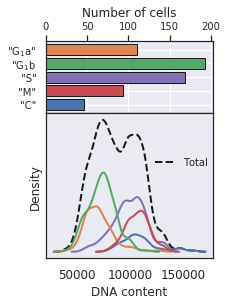

In [9]:
x_target = 'DCV: Pacific Blue-A'
cluster = 'sub_cell_cycle'
fig, axs = plt.subplots(figsize=(3, 4), nrows=2,
                        gridspec_kw = {'height_ratios':[3, 6]})
fig.subplots_adjust(hspace=0)
unique_cell_cycles = ['"G1 a"', '"G1 b"', '"S"', '"M"', '"C"']
converted = np.array([r'"G$_1$a"', r'"G$_1$b', '"S"', '"M"', '"C"'])
translate = {}
for i, k in enumerate(unique_cell_cycles):
    translate[k] = converted[i]
ylabels = {'"G1 a"':'1','"G1 b"': '2', '"S"':'3', '"M"':'4', '"C"':'5'}
cell_cc = np.array([translate[x] for x in adata_scv_rh.obs[cluster].values])
labels, counts = np.unique(cell_cc, return_counts=True)
color_order = np.unique(labels)
reind = [np.where(converted == x)[0][0] for x in color_order]
bw = 4000
bins = 20
val = np.linspace(0, 1, np.shape(np.unique(cell_cc))[0])
count = 0
for ind, u in zip(val[reind], color_order[reind]):
    w = counts[labels == u][0]
    o = adata_scv_rh.obs_names[cell_cc == u]
    kde = sat.smnp.KDEUnivariate(adata_scv_rh.obs.loc[o, x_target].values)
    kde.fit('gau', bw=bw)
    x_val, y = kde.support, kde.density
    adjusted_data = y*counts[labels == u][0]
    axs[1].plot(x_val, adjusted_data, color=plt.get_cmap(cell_cycle_cmap\
                )(ind),\
            lw=2, zorder=count+1)
    count += 1
kde = sat.smnp.KDEUnivariate(adata_scv_rh.obs[x_target].values)
kde.fit('gau', bw=bw)
x_val, y = kde.support, kde.density
axs[1].plot(x_val, y*counts.sum(), color='k', lw=2, ls='--', zorder=-10, label='Total')
axs[1].set_xlabel('DNA content', fontsize=12); axs[1].set_yticks([]);
axs[1].yaxis.set_label_position('left')
axs[1].tick_params(labelsize=12)
axs[1].set_ylabel('Density', fontsize=12)
axs[1].legend(frameon=False, loc=(0.63, 0.6), fontsize=10);
axs[1].grid(False)
reind = np.array([np.where(labels == u)[0][0] for u in converted])[::-1]
c = np.array([plt.get_cmap(cell_cycle_cmap)(i) for i in np.linspace(0, 1.001, len(labels))])
axs[0].barh(labels[reind], counts[reind],  height=0.8, color=c[reind],
            edgecolor='k', linewidth=1)
axs[0].tick_params(labelsize=10)
axs[0].xaxis.set_label_position('top')
axs[0].xaxis.tick_top()
axs[0].set_xlabel('Number of cells', fontsize=12, labelpad=5);
fig.savefig(output_dir+'fig2_sfig1a_dnaContent.pdf', bbox_inches='tight',
            transparent=True)

### Figure 2 - SFig 3e
### Fraction of parasite genes in each cluster

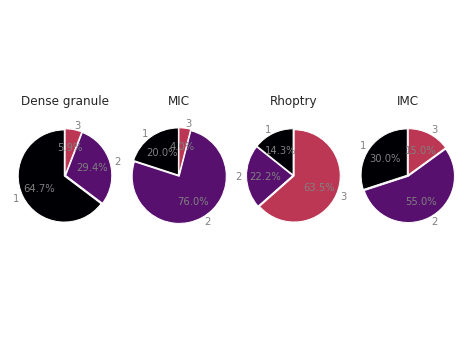

In [11]:
adata_rh = sc.read_h5ad(output_dir+'../Data/0701+0702/adata_sc_velocyto.h5ad')
cc_cluster = pd.read_csv(output_dir+'../Data/stable3_pseudotime_cluster_gene_assignment.tsv', index_col=0, sep='\t')
all_gene_id = ([x for x in adata_rh.var_names if 'ERCC' not in x])
all_gene_products = sat.get_product(all_gene_id, gpd_rh)
srs_genes = np.array([y for x, y in zip(all_gene_products, all_gene_id) if ' SRS' in x])
gra_genes = np.array([y for x, y in zip(all_gene_products, all_gene_id) if 'dense granule protein' in x])
mic_genes = np.array([y for x, y in zip(all_gene_products, all_gene_id) if 'microneme' in x])
rop_associated_genes = np.array([y for x, y in zip(all_gene_products, all_gene_id) if 'rhoptry' in x])
imc_genes = np.array([y for x, y in zip(all_gene_products, all_gene_id) if 'IMC' in x])
all_clusters = np.array(['1', '2', '3', 'Unknown'])
cmap = 'inferno'
color_dict = {y:plt.get_cmap(cmap)(x/len(all_clusters)) for x, y in
              enumerate(all_clusters)}

fig, axs = plt.subplots(figsize=(8, 6), ncols=4)
fig.subplots_adjust(wspace=0.1)
for ax, g, t in zip(axs, [gra_genes, mic_genes, rop_associated_genes,
                          imc_genes], ['Dense granule', 'MIC', 'Rhoptry', 'IMC']):
    clusters = cc_cluster.loc[g, 'pseudotime_cluster'].values.astype(str)
    subset = clusters != 'Unknown'
    lb, cnt = np.unique(clusters, return_counts=True)
    ratio = cnt / cnt.sum() * 100
    color = [color_dict[x] for x in lb]
    ax.pie(ratio, explode=[0.05,0.05,0.05], labels=lb, autopct='%1.1f%%',
           shadow=False, startangle=90,
           colors=color,textprops={'color':'grey', 'fontsize':10}, radius=3)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax.set_title(t, fontsize=12, y=0.7)
fig.savefig(output_dir+'fig2_sfig3e_piechart.pdf', bbox_inches='tight', transparent=True)

## Figure 2f

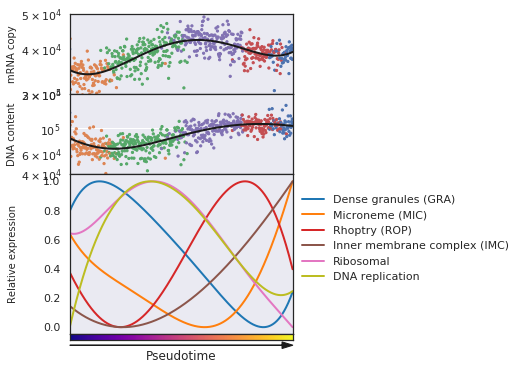

In [12]:
adata_allg_rh = sc.read_h5ad(output_dir+'../Data/0701+0702/adata_allg.h5ad')
adata_scv_rh = sc.read_h5ad(output_dir+'../Data/0701+0702/adata_sc_velocyto.h5ad')
all_gene_id = ([x for x in adata_allg_rh.var_names if 'ERCC' not in x])
all_gene_products = sat.get_product(all_gene_id, gpd_rh)
srs_genes = np.array([y for x, y in zip(all_gene_products, all_gene_id) if ' SRS' in x])
gra_genes = np.array([y for x, y in zip(all_gene_products, all_gene_id) if 'dense granule protein' in x])
mic_genes = np.array([y for x, y in zip(all_gene_products, all_gene_id) if 'microneme' in x])
rop_associated_genes = np.array([y for x, y in zip(all_gene_products, all_gene_id) if 'rhoptry' in x])
imc_genes = np.array([y for x, y in zip(all_gene_products, all_gene_id) if 'IMC' in x])
ribosomal_genes = np.array([y for x, y in zip(all_gene_products, all_gene_id) if 'ribosom' in x])
replication_genes = np.array([y for x, y in zip(all_gene_products, all_gene_id) if 'DNA replication' in x])
pt_order = adata_allg_rh.obs_names[np.argsort(adata_allg_rh.obs['monocle_cc_pseudotime'].values)]
norm_df, residuals = sat.pseudotime.smooth_data(np.log2(adata_allg_rh[pt_order].X.A+1), k=3)
norm_df[norm_df < 0] = 0
norm_df = np.nan_to_num(norm_df)
norm_df = norm_df / norm_df.max(axis=0)
norm_df = pd.DataFrame(norm_df, index=adata_allg_rh.obs_names,
                       columns=adata_allg_rh.var_names)
rna_abs = adata_scv_rh[pt_order].obs['absolute_amount'].values
rna_smooth, __ = sat.pseudotime.smooth_data(rna_abs, k=5)
dna_facs = adata_allg_rh[pt_order].obs['DCV: Pacific Blue-A'].values
dna_smooth, __ = sat.pseudotime.smooth_data(dna_facs, k=5)
x_vector = np.arange(np.shape(dna_facs)[0])
smooth_vector = []
for g in [srs_genes, gra_genes, mic_genes, rop_associated_genes, imc_genes, ribosomal_genes, replication_genes]:
    smooth_again, __ = sat.pseudotime.smooth_data(norm_df[g].mean(axis=1).values, k=5)
    smooth_vector.append(sat.ut.normalizer(smooth_again))

unique_colors, color_ind = \
        np.unique(adata_allg_rh[pt_order].obs['sub_cell_cycle'].values,
                  return_inverse=True)
lw = 2
fig, axs = plt.subplots(figsize=(4,6), nrows=4, sharex=True,
                        gridspec_kw = {'height_ratios':[3, 3, 6, 0.2]})
ax4, ax3, ax, ax2 = axs
fig.subplots_adjust(hspace=0)
cmap = 'tab10'
families = ['GRA', 'MIC', 'ROP', 'IMC', 'Ribosomal', 'DNA replication']
color_cdict = {y:plt.get_cmap(cmap)(x/len(families)) for x, y
               in enumerate(families)}
ax.plot(smooth_vector[1], label='Dense granules (GRA)', lw=lw,
        color=color_cdict['GRA'])
ax.plot(smooth_vector[2], label='Microneme (MIC)', lw=lw,
        color=color_cdict['MIC'])
ax.plot(smooth_vector[3], label='Rhoptry (ROP)', lw=lw,
        color=color_cdict['ROP'])
ax.plot(smooth_vector[4], label='Inner membrane complex (IMC)',
        lw=lw, color=color_cdict['IMC'])
ax.plot(smooth_vector[5], label='Ribosomal', lw=lw,
        color=color_cdict['Ribosomal'])
ax.plot(smooth_vector[6], label='DNA replication', lw=lw,
        color=color_cdict['DNA replication'])
ax.set_ylabel('Relative expression', labelpad=25, fontsize=10)
ax3.scatter(x_vector, dna_facs, s=5, c=color_ind, cmap=cell_cycle_cmap)
ax3.plot(dna_smooth, lw=lw, color='k')
ax3.set_ylim((4*10**4, 2*10**5))
ax3.set_ylabel('DNA content', fontsize=10)
ax3.set_yscale('log')
ax4.set_ylabel('mRNA copy', fontsize=10)
ax4.scatter(x_vector, rna_abs, s=5, c=color_ind/max(color_ind),
            cmap=cell_cycle_cmap)
ax4.set_ylim((3*10**4, 5*10**4))
ax4.plot(rna_smooth, lw=lw, color='k')
ax4.set_yscale('log')
ax2.imshow([np.arange(norm_df.shape[0]), np.arange(norm_df.shape[0])]*20 ,
           cmap='plasma', aspect='auto')
ax2.set_xlabel('Pseudotime', labelpad=10)
ax2.arrow(0, 80, np.shape(norm_df)[0]-30, 0, clip_on=False, color='k',
          head_width=50, head_length=30)
ax2.set_yticks([])
ax.set_xlim(0, norm_df.shape[0])
ax.set_xticks([])
ax.legend(loc=(1.02, 0.3), frameon=False)
ax.grid(False)
fig.savefig(output_dir+'fig2f.pdf', transparent=True, bbox_inches='tight')

### Figure 2b
### Pseudotime smoothen

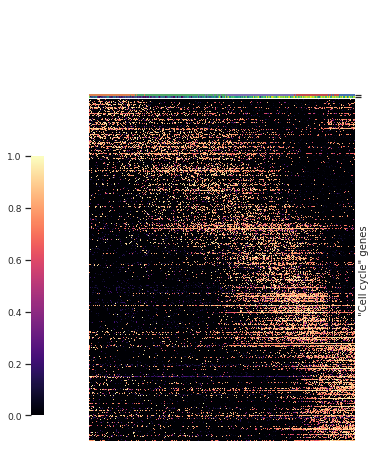

In [13]:
pt_order = adata_scv_rh.obs_names[np.argsort(adata_scv_rh.obs['monocle_cc_pseudotime'].values)]
X = pd.DataFrame(np.log2(adata_rh[pt_order].X.A+1), columns=adata_scv_rh.var_names)
smooth_X, residuals = sat.pseudotime.smooth_data(X, k=3)
smooth_X[smooth_X < 0] = 0
smooth_X = np.nan_to_num(smooth_X)
smooth_X = smooth_X / smooth_X.max(axis=0)
norm_X = pd.DataFrame(smooth_X, index=np.arange(1, np.shape(smooth_X)[0]+1),\
                     columns=X.columns)
norm_X = (sat.ut.normalizer(norm_X))
norm_X.columns = norm_X.columns.rename('genes')
max_norm_X = X.div(X.max(axis=0), axis=1)
max_norm_X.columns.names = ['"Cell cycle" genes']
max_norm_X.index.names = [' ']
monocle_genes = adata_allg_rh.var_names[
                adata_allg_rh.var['monocle_cc_sigGenes'].values]
used_for_projection = [True if x == 'True' else False for x in
         adata_scv_rh.var['used_for_projection'].values]
variable_genes = adata_scv_rh.var_names[used_for_projection]
#### Gene expression heatmap
## We will cluster genes based on cell cycle variation
## To do this, will apply double smoothing to the log2(data+1)
pt_order = adata_scv_rh.obs_names[np.argsort(
            adata_scv_rh.obs['monocle_cc_pseudotime'].values)]
rop_localizing_genes = pd.read_csv(input_folder_dir+
                                   'rhoptry_localizing_me49.csv', sep=',',
                                  index_col=0)
intersect_genes = np.intersect1d(rop_localizing_genes.index.values,
                                 adata_allg_rh.var_names.values)
rop_localizing_genes = rop_localizing_genes.loc[intersect_genes]
rop_localizing_genes['annotation'] = sat.get_product(rop_localizing_genes.index,
                                                     gpd_rh)
norm_df, residuals = sat.pseudotime.smooth_data(np.log2(
                        adata_scv_rh[pt_order].X.A+1), k=3)
norm_df[norm_df < 0] = 0
norm_df = np.nan_to_num(norm_df)
norm_df = norm_df / norm_df.max(axis=0)
norm_df = pd.DataFrame(norm_df, index=np.arange(1, np.shape(norm_df)[0]+1),
                       columns=adata_scv_rh.var_names)
rna_abs = adata_scv_rh[pt_order].obs['absolute_amount'].values
rna_smooth, __ = sat.pseudotime.smooth_data(rna_abs, k=5)
dna_facs = adata_scv_rh[pt_order].obs['DCV: Pacific Blue-A'].values
dna_smooth, __ = sat.pseudotime.smooth_data(dna_facs, k=5)
x_vector = np.arange(np.shape(dna_facs)[0])
used_for_projection = [True if x == 'True' else False for x in
         adata_scv_rh.var['used_for_projection'].values]
variable_genes = adata_scv_rh.var_names[used_for_projection]

genes = norm_df.columns.values[(np.greater(norm_df, 0).sum(axis=0) > 2)]
smooth_again_all, __ = sat.pseudotime.smooth_data(norm_df[genes].values, k=5)
gene_clusters = sklearn.cluster.AgglomerativeClustering(affinity='correlation',
            linkage='average', n_clusters=3).fit_predict(smooth_again_all.T)
gene_clusters = (gene_clusters+1).astype(str)
if 'cc_cluster' not in adata_rh.var.columns.values:
    adata_rh.var['cc_cluster'] = 'Unknown'
    adata_rh.var.loc[genes, 'cc_cluster'] = gene_clusters.astype(str)
mean_order = []
re_ordered_gene_clusters = np.array([], dtype=int)
sorted_gene_list = []
gene_clusters = sklearn.cluster.AgglomerativeClustering(affinity='correlation',
                linkage='average', n_clusters=5).fit_predict(
                    norm_df[variable_genes].T)
gene_clusters = (gene_clusters+1).astype(str)
col1, col2 = adata_scv_rh[pt_order].obs['sub_cell_cycle'].values,\
            adata_scv_rh[pt_order].obs['DCV: Pacific Blue-A'].values
for u in np.unique(gene_clusters):
    curr = (variable_genes[gene_clusters == u])
    mean = norm_df[curr].idxmax().mean()
    mean_order.append(mean)
mean_order = np.argsort(np.array(mean_order))
mean_order = ['5', '1', '3', '4', '2']
for u in mean_order:
    curr = (variable_genes[gene_clusters == u])
    sorted_gene_list = np.append(sorted_gene_list, curr[np.argsort(
                                     norm_df[curr].idxmax().values)])
    re_ordered_gene_clusters = np.append(re_ordered_gene_clusters,
                                         np.repeat(u, np.shape(curr)[0]))
cluster_colors = adata_rh.var.loc[sorted_gene_list, 'cc_cluster']
out = sat.plot.heatmap(max_norm_X[sorted_gene_list], figsize=(6,8),
                       col_cluster=False,\
                       col_name=['  ', ' '],\
                            col_colors=[col1, col2],\
                       dpi=800, row_name=' ', \
                        col_cmap=[cell_cycle_cmap, 'viridis'],
                        row_cluster=False, row_cmap='inferno', cmap='magma',
                       filename=output_dir+'fig2b_maxnorm.png')

### Figure 2 - SFig 3f

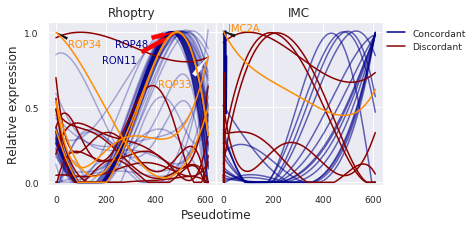

In [14]:
adata_rh = sc.read_h5ad(output_dir+'../Data/0701+0702/adata_sc_velocyto.h5ad')
cc_cluster = pd.read_csv(output_dir+'../Data/stable3_pseudotime_cluster_gene_assignment.tsv',
                         index_col=0, sep='\t')
cluster = pd.DataFrame(cc_cluster.loc[adata_rh.var_names,
                                      'pseudotime_cluster'].values.astype(int),
                       index=adata_rh.var_names, columns=['c'], dtype=str)
all_gene_family = [rop_associated_genes, imc_genes]
all_gene_family = [[y for y in x if y in norm_df.columns.values] for x
                   in all_gene_family]
imc_2a = 'TGGT1_228170'
rop_33 = 'TGGT1_201130'
rop_34 = 'TGGT1_240090'
rop48 = 'TGGT1_218270'
ron11 = 'TGGT1_230350'
ron12 = 'TGGT1_232020'
titles = ['Rhoptry', 'IMC']

fig, axs = plt.subplots(figsize=(6, 3), ncols=2, sharey=True)
fig.subplots_adjust(wspace=0)
genes = [imc_2a, rop_33, rop_34, rop48, ron11]
smooth_again, __ = sat.pseudotime.smooth_data(
    norm_df[genes].values, k=5)
smooth_again[smooth_again < 0] = 0
for i, lb in zip(smooth_again.T, ['IMC2A', 'ROP33', 'ROP34', 'ROP48', 'RON11']):
    if lb == 'IMC2A':
        axs[1].plot(i, color='darkorange', zorder=10)
        axs[1].annotate(lb, xy=(np.argmax(i), i.max()), color='darkorange',
                        xytext=(np.argmax(i)+20, i.max()),
                     arrowprops=dict(facecolor='k', shrink=0.05, headwidth=2,
                                edgecolor='k', frac=0.01))
    else:
        axs[0].plot(i, color='darkorange', zorder=10)
        if lb == 'ROP33':
            move = -200
            y = -0.2
            color = 'darkorange'
            acolor = 'white'
        elif lb == 'ROP34':
            move = 50
            y = -0.1
            color = 'darkorange'
            acolor = 'black'
        elif lb == 'ROP48':
            move = -250
            y = -0.1
            color = 'darkblue'
            acolor = 'red'
        elif lb == 'RON11':
            move = -300
            y = -0.2
            color = 'darkblue'
            acolor = 'red'
        axs[0].annotate(lb, xy=(np.argmax(i), i.max()), color=color,
                        xytext=(np.argmax(i)+move, i.max()+y),
                     arrowprops=dict(facecolor='k', color=acolor,
                                     shrink=0.05, headwidth=2, linewidth=0.5,
                                edgecolor='k', frac=0.01))
genes = np.setdiff1d(all_gene_family[0], [rop_33, rop_34])
smooth_again, __ = sat.pseudotime.smooth_data(
    norm_df[genes].values, k=5)
smooth_again[smooth_again < 0] = 0
sub_c = cluster.loc[genes, 'c'].values.astype(str)
axs[0].set_title(titles[0], fontsize=12)
subset = sub_c != '1'
axs[0].plot(smooth_again[:, subset], color='darkblue', alpha=0.3)
axs[0].plot(smooth_again[:, subset==False], color='darkred')
genes = np.setdiff1d(all_gene_family[1], [imc_2a])
smooth_again, __ = sat.pseudotime.smooth_data(
    norm_df[genes].values, k=5)
smooth_again[smooth_again < 0] = 0
sub_c = cluster.loc[genes, 'c'].values
axs[1].set_title(titles[1], fontsize=12)
subset = sub_c != '1'
axs[1].plot(smooth_again[:, subset][:-1], color='darkblue', alpha=0.6)
axs[1].plot(smooth_again[:, subset==False][:-1], color='darkred')
axs[1].plot(smooth_again[:, subset][-1], color='darkblue', label='Concordant')
axs[1].plot(smooth_again[:, subset==False][-1], color='darkred',
            label='Discordant')
labels = np.array([x.split(' ')[-1] for x in
                   sat.get_product(genes[subset == False], gpd)])
argmax = np.argmax(smooth_again[:, subset==False], axis=0)
pos = np.array([x[argmax[i]] for i, x in
                enumerate(smooth_again[:, subset==False].T)])
pos = np.array([argmax, pos]).T
for i, X in enumerate(pos):
    axs[1].annotate(labels[i], xy=(X[0], X[1]), color='darkred',
                    xytext=(X[0], X[1]), arrowprops=dict(facecolor='k',
                                                         color='darkred',
                                 shrink=0.05, headwidth=2, linewidth=0.5,
                            edgecolor='k', frac=0.01))
for ax in axs:
    ax.set_yticks([0, 0.5, 1.0])
    ax.set_ylim(-0.02, )
axs[0].set_ylabel('Relative expression', fontsize=12)
axs[1].set_xlabel('Pseudotime', x=0, fontsize=12)
axs[1].legend(frameon=False, loc=(1.0, 0.8))
fig.savefig(output_dir+'fig2_sfig3f_pseudotime_disagreement.pdf',
            bbox_inches='tight', transparent=True)

### Figure 2 - SFig 3

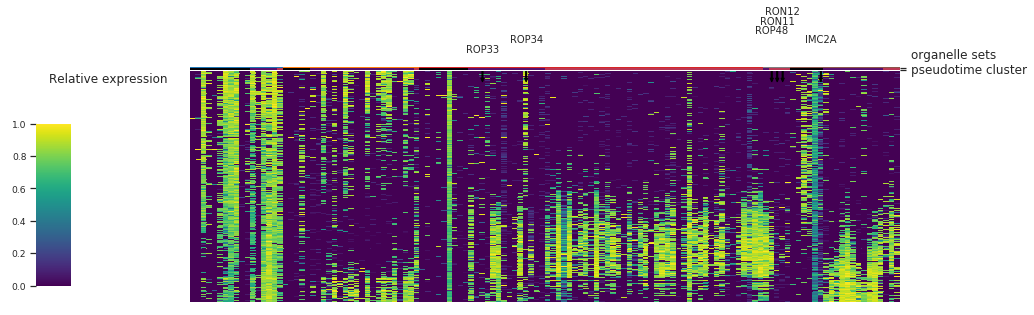

In [17]:
all_gene_id = ([x for x in adata_rh.var_names if 'ERCC' not in x])
all_gene_products = sat.get_product(all_gene_id, gpd_rh)
srs_genes = np.array([y for x, y in zip(all_gene_products, all_gene_id) if ' SRS' in x])
gra_genes = np.array([y for x, y in zip(all_gene_products, all_gene_id) if 'dense granule protein' in x])
mic_genes = np.array([y for x, y in zip(all_gene_products, all_gene_id) if 'microneme' in x])
rop_associated_genes = np.array([y for x, y in zip(all_gene_products, all_gene_id) if 'rhoptry' in x])
imc_genes = np.array([y for x, y in zip(all_gene_products, all_gene_id) if 'IMC' in x])
ribosomal_genes = np.array([y for x, y in zip(all_gene_products, all_gene_id) if 'ribosom' in x])
replication_genes = np.array([y for x, y in zip(all_gene_products, all_gene_id) if 'DNA replication' in x])

## concordant and discordant genes heatmap
import adjustText
cluster = pd.DataFrame(cc_cluster['pseudotime_cluster'].values,
                       index=cc_cluster.index, columns=['c'], dtype=str)
positive_rop_genes = ['TGGT1_218270', 'TGGT1_230350', 'TGGT1_232020',
                      'TGGT1_253370', 'TGGT1_261740']
negative_genes = ['TGGT1_228170', 'TGGT1_201130', 'TGGT1_240090', 'TGGT1_218270',
                  'TGGT1_230350', 'TGGT1_232020']
negative_product = ['IMC2A', 'ROP33', 'ROP34', 'ROP48', 'RON11', 'RON12']
rop_localizing_genes = pd.read_csv(input_folder_dir+
                                   'rhoptry_localizing_me49.csv', sep=',',
                                  index_col=0)
pos_product = rop_localizing_genes.loc[positive_rop_genes, 'product'].values
pos_product = [x.split(' ')[-1].replace('(','').replace(')','') for x in
               pos_product]
all_gene_family = [gra_genes, mic_genes, rop_associated_genes,
                   positive_rop_genes, imc_genes]
all_gene_family = [[y for y in x if cc_cluster.loc[y, 'pseudotime_cluster']
                   != 'Unknown'] for x in all_gene_family]
t = ['GRA', 'MIC', 'ROP', 'IMC']
cmap = 'tab10'
family_cdict = {y:plt.get_cmap(cmap)(x/6) for x, y in enumerate(t)}
family_cdict['Validated ROP'] = plt.get_cmap(cmap)(0.7)
families = ['GRA', 'MIC', 'ROP', 'Validated ROP', 'IMC']
titles = ['Dense granule', 'MIC', 'Rhoptry','Validated ROP', 'IMC']
number_of_plot = len(all_gene_family)
cmap = 'inferno'
all_clusters = np.array(['1', '2', '3', 'Unknown'])
color_dict = {y:plt.get_cmap(cmap)(x/len(all_clusters)) for x, y in
              enumerate(all_clusters)}
count = 0
values, colors, family_colors = [], [], []
for genes, t in zip(all_gene_family, titles):
    sub_cluster = cluster.loc[genes]
    order = np.argsort(sub_cluster.values.flatten())
    genes = np.array(genes)[order]
    sub_cluster = sub_cluster.iloc[order].values.flatten()
    values = np.concatenate([values, genes])
    colors = np.concatenate([colors, sub_cluster])
for i, g in enumerate(all_gene_family):
    family_colors = np.concatenate([family_colors, np.repeat(families[i],
                                                             len(g))])
pt_order = adata_scv_rh.obs_names[np.argsort(adata_scv_rh.obs['monocle_cc_pseudotime'].values)]
X = pd.DataFrame(np.log2(adata_rh[pt_order].X.A+1), columns=adata_scv_rh.var_names)
X = X[values]
max_norm_X = X.div(X.max(axis=0), axis=1)
plot = sat.plot.heatmap(max_norm_X[values].T, cmap='viridis', row_cluster=False,
                 col_cluster=False, col_colors=[family_colors, colors],
                        figsize=(16, 5), col_name=[' ', '  '],
                        col_cmap=[family_cdict, color_dict],
                        run=False)
ax = plot.g.ax_heatmap
x_array = np.arange(len(values))
lastx = x_array[values == negative_genes[0]]
y = -50
for g, t in zip(negative_genes, negative_product):
    pos = x_array[values == g] + 0.5
    if abs(lastx - pos) < 50:
        y -= 25
    else:
        y = -50
    dy = y - (-30)
    ax.text(pos, y, t, fontsize=10, ha='center')
    ax.arrow(pos, -1, 0, 20, width=0.2, zorder=100,
             color='black', head_length=10)
    lastx = pos
ax.set_xlabel('')
ax.text(len(values)+2, -25, 'organelle sets', ha='left', va='bottom', fontsize=12)
ax.text(len(values)+2, 5, 'pseudotime cluster', ha='left', fontsize=12)
ax.text(-0.2, 0.95, 'Relative expression', transform=ax.transAxes,
        fontsize=12, ha='left')
plot.g.savefig(output_dir+'fig2_sfig1_gene_clusters.pdf', bbox_inches='tight', dpi=500)

### Figure 2a

saving figure to file /home/soso/GitRepositories/singleToxoplasmaSeq/Submission_analysis/Scripts/_loadlib/../../Figures/velocity_pca_fig2a_pca_velocity.pdf


<Figure size 144x432 with 0 Axes>

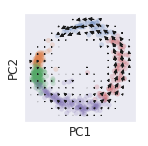

In [20]:
import matplotlib as mpl
label_order = ['"G1 a"', '"G1 b"', '"S"', '"M"', '"C"']
s = 10
fig, axs = plt.subplots(figsize=(2, 6), nrows=3)
fig.subplots_adjust(hspace=0)
pos = adata_scv_rh.obsm['X_pca'][:, :2]
labels = adata_scv_rh.obs['sub_cell_cycle'].values
translate = {}
converted = [r'"G$_1$a"', r'"G$_1$b', '"S"', '"M"', '"C"']
for i, k in enumerate(label_order):
    translate[k] = converted[i]
labels = np.array([translate[k] for k in labels])
cc_cdict_real = {y:cell_cycle_cmap(x) for x, y in enumerate(np.unique(
                converted))}
for ind, u in enumerate(converted):
    c = cc_cdict_real[u]
    subset = (labels == u)
    axs[1].scatter(pos[subset,0], pos[subset, 1], color=c, s=s,
                   label=u)
leg = axs[1].legend(markerscale=2, frameon=False, loc=(.95, 0.0),
                    labelspacing=0.5)
axs[1].text(1.05, 0.8, 'Inferred state', fontsize=12,
            transform=axs[1].transAxes)
leg._legend_box.align='left'
dna_content = adata_scv_rh.obs['DCV: Pacific Blue-A'].values
order = np.argsort(-dna_content)
artist = axs[0].scatter(pos[order,0], pos[order,1], c=dna_content[order],
              cmap='viridis', s=s)
cax = plt.axes([0.5, 0.63, 0.5, 0.2])
cax.set_visible(False)
fmt = sat.plot.FormatScalarFormatter("%.1f")
cb = fig.colorbar(artist, ax=cax, format=fmt)
cb.formatter.set_powerlimits((0,0))
cb.ax.yaxis.set_offset_position('left')
cb.ax.set_title('DNA content', fontsize=12, ha='left', y=1.1)
for ax in axs:
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_facecolor('lightgrey')
axs[2].set_xlabel('PC1', fontsize=12)
axs[0].set_ylabel('PC2', fontsize=12)
axs[1].set_ylabel('PC2', fontsize=12)
axs[2].set_ylabel('PC2', fontsize=12)
fig.savefig(output_dir+'fig2a_pca_cell_cycle.pdf', bbox_inches='tight')
try:
    del(adata_scv_rh.uns['sub_cell_cycle_colors'])
except:
    pass
scv.pl.velocity_embedding_grid(adata_scv_rh, basis='pca', color='sub_cell_cycle',
                         arrow_length=1.5, arrow_size=5, size=100,
                               linewidth=1, density=0.3, arrow_color='k',
                               figsize=(2, 2),
                               legend_fontsize=12, alpha=0.2, title='',
                               save='fig2a_pca_velocity.pdf');

### Figure 2 SFig 3b

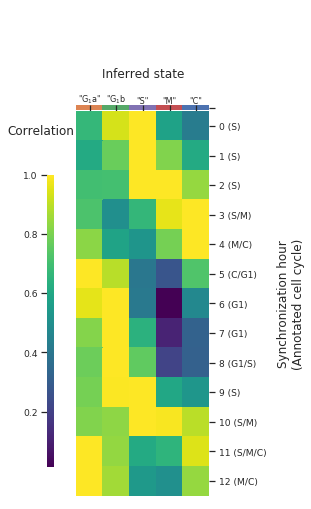

In [22]:
adata_allg_rh = sc.read_h5ad(output_dir+'../Data/0701+0702/adata_allg.h5ad')
adata_scv_rh = sc.read_h5ad(output_dir+'../Data/0701+0702/adata_sc_velocyto.h5ad')
behnke_data = pd.read_csv(input_folder_dir+'toxodb_microarray_data.txt', index_col=0, sep='\t')
only_spline_smoothed = [x for x in behnke_data.columns if 'cycle' in x.lower()
                        and '- spline smoothed' in x]
behnke_data = behnke_data[only_spline_smoothed]
behnke_data = behnke_data.copy()
behnke_data.index = [x.replace('TGME49', 'TGGT1') for x in behnke_data.index]
sam_high_ranked = [True if x == 'True' else False for x in
                   adata_scv_rh.var['sam_high_ranked'].values]
overlapping_genes = np.array([x for x in adata_scv_rh.var_names[
    sam_high_ranked] if x in behnke_data.index])
behnke_cell_cycle_state = ['S', 'S' ,'S', 'S/M', 'M/C', 'C/G1', 'G1', 'G1', 'G1/S', 'S', 'S/M', 'S/M/C', 'M/C']
cluster = 'sub_cell_cycle'
cluster_averaged = sat.average_by_clusters(pd.DataFrame(np.log2(adata_scv_rh.X.A+1), index=adata_scv_rh.obs_names, columns=adata_scv_rh.var_names),\
                                           return_clusters=True, \
                                           clusters=adata_scv_rh.obs[cluster].values)
X1 = (behnke_data.T[overlapping_genes])
X1.index = [x.split('-')[1].strip().strip(' HR') for x in X1.index]
X1.index = [x + ' (' + y +')' for x,y in zip(X1.index, behnke_cell_cycle_state)]
X2 = cluster_averaged[overlapping_genes]
X2 = X2.loc[['"G1 a"', '"G1 b"', '"S"', '"M"', '"C"']]
label_order = np.array(['"G1 a"', '"G1 b"', '"S"', '"M"', '"C"'])
converted = np.array([r'"G$_1$a"', r'"G$_1$b', '"S"', '"M"', '"C"'])
translate = {}
for i, k in enumerate(label_order):
    translate[k] = converted[i]
new_labels = np.array([translate[k] for k in X2.index.values])
unique_labels = np.unique(new_labels)
reind = [np.where(unique_labels == x)[0][0] for x in converted]
X2.index = new_labels
cross_corr = sat.mat_corr(X1.T, X2.T)
cross_corr = cross_corr / cross_corr.max(axis=0)
cross_corr.index = ['1', '2', '3', '4', '5']
plot = sat.plot.heatmap(cross_corr, cmap='viridis', col_cmap=cell_cycle_cmap,
                        col_colors=reind, col_cluster=False, row_cluster=False,
                        showxticks=True, run=False, col_name='',figsize=(3, 9),
                        showyticks=True)
fig, ax = plot.g.fig, plot.g.ax_heatmap
ax.yaxis.set_label_position(position='right')
ax.xaxis.set_ticks_position(position='top')
ax.set_xticklabels(X2.index.values)
ax.set_title('Inferred state', fontsize=12, pad=15);
ax.set_ylabel('Synchronization hour\n(Annotated cell cycle)', fontsize=12,
             labelpad=10)
ax.tick_params(axis='x', rotation=0, labelsize=8, pad=0)
ax.text(-2.6, 0.8, 'Correlation', fontsize=12)
fig.savefig(output_dir+'fig2_sfig1b_agreement_behnke_study_velocity_clusters.pdf',
            bbox_inches='tight', transparent=True)

### Figure 3

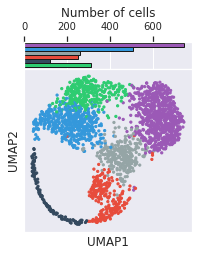

In [23]:
cluster = 'louvain'
pos = adata_scv_pru.obsm['X_umap']
ulab = (np.unique(adata_scv_pru.obs[cluster].values))
tdict = {y:x for x, y in enumerate(ulab)}
size = len(ulab)
color = [tdict[x]/size for x in (adata_scv_pru.obs[cluster].values)]
fig, axs = plt.subplots(figsize=(3, 3.5), nrows=2,
                        gridspec_kw = {'height_ratios':[.5, 3]})
fig.subplots_adjust(hspace=0)
labels, counts = np.unique(adata_scv_pru.obs['louvain'].astype(str), return_counts=True)
for x, y, c in zip(labels[::-1], counts[::-1], flatui[::-1]):
    axs[0].barh(x, y, color=c, edgecolor='k', height=1)
axs[0].set_xlabel('Number of cells', fontsize=12, labelpad=5)
axs[0].xaxis.set_label_position('top')
axs[0].xaxis.tick_top()
axs[0].set_yticks([])
axs[0].tick_params(labelsize=10)
axs[1].set_yticks([])
axs[1].set_xticks([])
axs[1].scatter(pos[:,0], pos[:,1], c=color, cmap=louvain_cmap, s=5)
axs[1].set_xlabel('UMAP1', fontsize=12)
axs[1].set_ylabel('UMAP2', fontsize=12)
fig.savefig(output_dir+'fig3a_umap_pru.pdf', bbox_inches='tight',
            transparent=True)

### Figure 3

saving figure to file /home/soso/GitRepositories/singleToxoplasmaSeq/Submission_analysis/Scripts/_loadlib/../../Figures/velocity_umap_rv_umap_cc_grid.pdf


<Figure size 432x288 with 0 Axes>

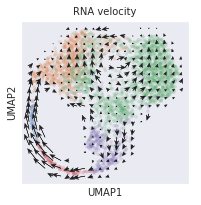

In [24]:
adata_scv_pru.uns['cell_cycle_colors'] = [cell_cycle_cmap(x) for
                                      x in np.linspace(0, 1, 4)]
scv.pl.velocity_embedding_grid(adata_scv_pru, basis='umap',
                               color='cell_cycle', legend_loc='none', \
                           alpha=0.2, arrow_color='k', title='RNA velocity',
         arrow_length=2, arrow_size=5, size=50, linewidth=0.4, density=0.4,\
        figsize=(3, 3), legend_fontsize=12, frameon=True,\
                               save='rv_umap_cc_grid.pdf');

### Figure 3

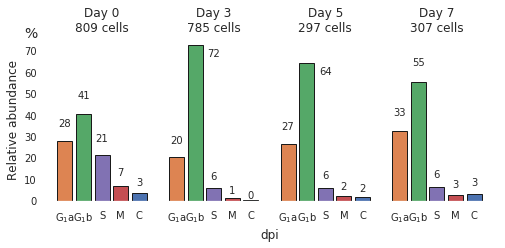

In [25]:
fig, axs = plt.subplots(figsize=(8, 3), ncols=4, sharey=True)
fig.subplots_adjust(wspace=0)
unique_labels = np.array(['"G1 a"', '"G1 b"', '"S"', '"M"', '"C"'], dtype=str)
label_dict = {u:x for u, x in zip(unique_labels, [r'G$_1$a', r'G$_1$b',
'S', 'M', 'C'])}
lspace = np.linspace(0,1,np.shape(unique_labels)[0])
color_dict = {}
for ind, i in enumerate(np.sort(unique_labels)):
    color_dict[i] = lspace[ind]
for ind, day in enumerate(np.unique(adata_allg_pru.obs['dpi'].values)):
    labels, raw_counts = np.unique(adata_allg_pru.obs['cell_cycle'][
    adata_allg_pru.obs['dpi'].values == day], return_counts=True)
    counts = raw_counts/raw_counts.sum()*100
    for ind2, i in enumerate(unique_labels):
        y = counts[labels == str(i)][0]
        axs[ind].bar(label_dict[i], y, \
                     color=plt.get_cmap(cell_cycle_cmap)(color_dict[i]),\
                     edgecolor='k', lw=1, width=0.8)
        if y > 60:
            b = 1
            c = -5
        else:
            b = 0
            c = np.log2(y)+2
        axs[ind].annotate(int(np.round(y, 0)), xy=(ind2, y),
                            xytext=(ind2+b,y+c), ha='center')
        axs[ind].tick_params(labelsize=10)
        axs[ind].set_xlim(-1, 5)
        axs[ind].grid(False)
        axs[ind].set_facecolor('w')
    title = day + '\n' + str(raw_counts.sum()) + ' cells'
    axs[ind].set_title(title, fontsize=12)
axs[0].text(-0.2, 1, '%', transform=axs[0].transAxes, fontsize=14);
axs[0].set_ylabel('Relative abundance', fontsize=12)
axs[2].set_xlabel('dpi', fontsize=12, x=0)
fig.savefig(output_dir+'fig3_sfig4b_cc_abundance.pdf', bbox_inches='tight', transparent=True);

### Figure 3

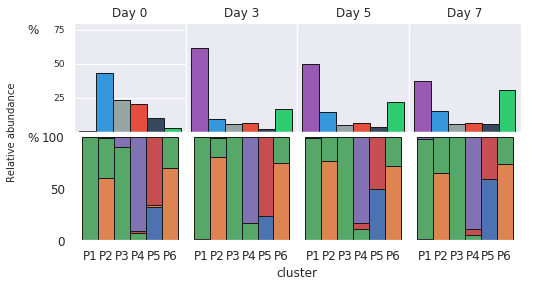

In [26]:
order = ['"G1 a"', '"G1 b"', '"S"', '"M"', '"C"']
cell_cycle = adata_scv_pru.obs['cell_cycle']
cluster = adata_scv_pru.obs['louvain']
dpi = adata_scv_pru.obs['dpi']
composition_df = pd.DataFrame(0, index=np.unique(cluster), columns = np.unique(cell_cycle))
for u in np.unique(cluster):
    cc, counts = np.unique(cell_cycle[cluster == u], return_counts=True)
    composition_df.loc[u, cc] = counts/np.sum(counts)
day0_df = pd.DataFrame(0, index=np.unique(cluster), columns = np.unique(cell_cycle))
day3_df = pd.DataFrame(0, index=np.unique(cluster), columns = np.unique(cell_cycle))
day5_df = pd.DataFrame(0, index=np.unique(cluster), columns = np.unique(cell_cycle))
day7_df = pd.DataFrame(0, index=np.unique(cluster), columns = np.unique(cell_cycle))
for day in np.unique(dpi):
    cells = cluster.index[dpi == day]
    curr_cluster = cluster.loc[cells].values
    curr_cell_cycle = cell_cycle.loc[cells].values
    for u in np.unique(curr_cluster):
        cc, counts = np.unique(curr_cell_cycle[curr_cluster == u], return_counts=True)
        if day == 'Day 0':
            day0_df.loc[u, cc] = counts/np.sum(counts)*100
        elif day == 'Day 3':
            day3_df.loc[u, cc] = counts/np.sum(counts)*100
        elif day == 'Day 5':
            day5_df.loc[u, cc] = counts/np.sum(counts)*100
        elif day == 'Day 7':
            day7_df.loc[u, cc] = counts/np.sum(counts)*100
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(8, 4))
fig.subplots_adjust(wspace=0, hspace=0)
width = 1
day0_df.plot(ax=axs[1, 0], kind='bar', rot=0, width=width, edgecolor='k', lw=1, stacked=True, legend=False, cmap=cell_cycle_cmap)
day3_df.plot(ax=axs[1, 1], kind='bar', rot=0, width=width, edgecolor='k', lw=1, stacked=True, legend=False, cmap=cell_cycle_cmap)
day5_df.plot(ax=axs[1, 2], kind='bar', rot=0, width=width, edgecolor='k', lw=1, stacked=True, legend=False, cmap=cell_cycle_cmap)
day7_df.plot(ax=axs[1, 3], kind='bar', rot=0, width=width, edgecolor='k', lw=1, stacked=True, legend=False, cmap=cell_cycle_cmap)
for ax in axs[1, :]:
    ax.tick_params(labelsize=12)
    ax.set_xlim(-1, 6)
    ax.grid(False)
    ax.set_facecolor('w')
axs[1, 0].text(-0.42, 0.91, '%', transform=axs[1,0].transAxes, fontsize=12);
axs[1, 2].set_xlabel('cluster', fontsize=12, x=0)

group = adata_scv_pru.obs['louvain']
composition_df = pd.DataFrame(0, index=['Day 0', 'Day 3', 'Day 5', 'Day 7'],
                columns=np.unique(group))
for i in ['Day 0', 'Day 3', 'Day 5', 'Day 7']:
    subset = (dpi == i).values
    lab, cnt = np.unique(group.values[subset], return_counts=True)
    composition_df.loc[i, lab] = cnt/np.sum(cnt)*100
xvals = range(composition_df.shape[1])
for ind, i in enumerate(composition_df.index.values):
    axs[0, ind].set_title(i, fontsize=12)
    vals = composition_df.loc[i].values
    for j, u in enumerate(vals):
        c = plt.get_cmap(louvain_cmap)(j/len(xvals))
        axs[0, ind].bar(xvals[j], u, color=c, width=width, lw=1, edgecolor='k')
for ax in axs[0, :]:
    ax.set_xticks([])
    ax.set_yticks([25,50,75])
    ax.set_ylim(0, 80)
for ax in axs[0, 1:]:
    ax.set_yticks([])
for ax in axs[1, 1:]:
    ax.set_yticks([])
axs[0, 0].text(-0.42, 1.9, '%', transform=axs[1,0].transAxes, fontsize=12);
fig.text(-0.6, 0, 'Relative abundance', rotation=90, va='center',
        transform=axs[0,0].transAxes)
fig.savefig(output_dir+'fig3_sfig4c_cluster_abundance.pdf',
            bbox_inches='tight', transparent=True)

### Figure 3

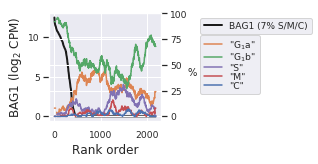

In [27]:
bag1_exp = np.log2(entire_df_pru['TGME49_259020'].values + 1)
expressed = bag1_exp > 2
unique, lbs = np.unique(adata_allg_pru.obs.loc[expressed, 'cell_cycle'],
                        return_counts=True)
lbs = lbs / expressed.sum() * 100
replicating_fraction = lbs[unique == '"S"'] + lbs[unique == '"M"'] +\
                        lbs[unique == '"C"']
replicating_fraction = np.round(replicating_fraction, 1)
order = np.argsort(-bag1_exp)
x = range(np.shape(order)[0])
y = bag1_exp[order]
fig, ax = plt.subplots(figsize=(2, 2))
ax.plot(x, y, lw=2, c='k', label='BAG1 (%i%% S/M/C)' %(replicating_fraction))
ax.set_ylabel(r'BAG1 (log$_2$ CPM)', fontsize=12)
ax.set_xlabel('Rank order', fontsize=12)
cc = adata_allg_pru.obs['cell_cycle'].values
label_order = ['"G1 a"', '"G1 b"', '"S"', '"M"', '"C"']
new_label_order = [r'"G$_1$a"', r'"G$_1$b"', '"S"', '"M"', '"C"']
colors = ['C1', 'C2', 'C4', 'C3', 'C0']
color_dict = {x:y for x, y in zip(new_label_order, colors)}
convert_dict = {x:y for x, y in zip(label_order, new_label_order)}
cc = np.array([convert_dict[x] for x in cc])
g = sat.plot.stratify(bag1_exp[order], cc[order], binsize=50, ax=ax,
                     ylabel='%', order_cbar_labels=new_label_order,
                     c=color_dict)
ax.legend(loc=(1.35, 0.8)); g.ax.legend(loc=(1.35, 0.25), labelspacing=0)
fig.savefig(output_dir+'fig3_sfig4d_bag1.pdf', bbox_inches='tight', transparent=True)

### Figure 3
### Bradyzoite and Tachyzoite marker genes

Number of plots: 6


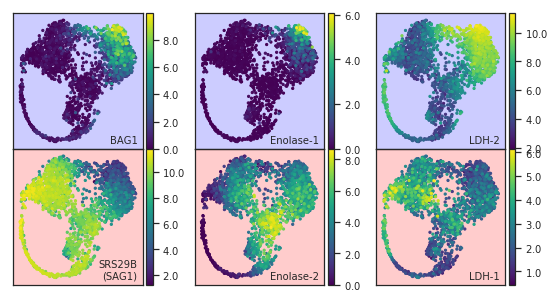

In [28]:
genes = ['TGME49_259020','TGME49_268860',
        'TGME49_291040', 'TGME49_233460', 'TGME49_268850', 'TGME49_232350']
titles = ['BAG1', 'Enolase-1',
        'LDH-2', 'SRS29B (SAG1)', 'Enolase-2', 'LDH-1']
c = [np.log2(adata_allg_pru[:,x].X.astype(float)+1) for x in genes]
adj = adata_scv_pru.uns['neighbors']['connectivities'].A
plot = sat.plot.scatter(adata_scv_pru.obsm['X_umap'], c=c, s=5, figsize=(3, 2.5),
                        adj=adj, ncols=3, wspace=0.15, run=False, hspace=0)
fig, axs = plot.run()
for ax in axs[:3]:
    ax.patch.set_facecolor('blue')
    ax.patch.set_alpha(0.2)
for ax in axs[3:]:
    ax.patch.set_facecolor('red')
    ax.patch.set_alpha(0.2)
for ax, t in zip(axs, titles):
    ax.text(0.96, 0.04, '\n'.join(t.split(' ')), fontsize=10, ha='right',
            transform=ax.transAxes)
fig.savefig(output_dir+'fig3_umap_tachy_brady.pdf', bbox_inches='tight')


### Figure 3 SFig 5
### Scatter plot of brady vs tachy genes

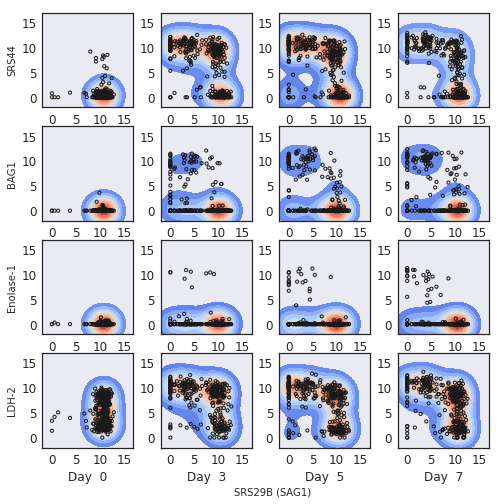

In [29]:
def separate_cluster_scatter(X, xaxis_gene, genes, labels, order_by=[], figsize=(3,3), \
                             filename='', title='', xlabel='', fontsize=12, ylabel=[],\
                             wspace=0.3, **args):
    assert len(genes) < 20, 'Too many genes provided. Limit is set to 20 genes'
    unique_labels = np.unique(labels)
    ncols = np.shape(unique_labels)[0]
    nrows = np.shape(genes)[0]
    figsize = (figsize[0]*ncols, figsize[1]*nrows)
    if len(order_by) > 0:
        assert np.setdiff1d(unique_labels, order_by) == 0,\
        'order_by does not contain all labels'
        unique_labels = np.array(order_by)
    if isinstance(adata_allg_pru, anndata.AnnData):
        X = pd.DataFrame(np.log2(X.X.A.copy()+1), index=X.obs_names, columns=X.var_names)
    fig, axs = plt.subplots(figsize=figsize, ncols=ncols, nrows=nrows)
    fig.subplots_adjust(wspace=wspace)
    axs = axs.T.flatten()
    count = 0
    for i in unique_labels:
        x = X.loc[labels == i, xaxis_gene].values
        y_subset = X.loc[labels == i, genes]
        for gene in genes:
            if len(ylabel) > 0 and count < nrows:
                axs[count].set_ylabel(ylabel[count])
            if (count%ncols) == (ncols-1):
                t = unique_labels[int(count/ncols)]
                if 'Day' in t:
                    t = t.replace('Day', 'Day ')
                axs[count].set_xlabel(t, fontsize=fontsize)
            y = y_subset[gene].values
            axs[count].scatter(x, y, s=10, zorder=10, edgecolor='k', c='')
            sns.kdeplot(x, y, ax=axs[count], cmap='coolwarm', shade=True, \
                        shade_lowest=False, bw=2, clip=((-2,20),(-2,20)))
            axs[count].set_xticks([0,5,10,15])
            axs[count].set_yticks([0,5,10,15])
            axs[count].tick_params(labelsize=fontsize, pad=0)
            axs[count].set_xlim(-2,17)
            axs[count].set_ylim(-2,17)
            axs[count].grid(False)
            count += 1
    fig.text(-0.5, -0.5, xlabel, transform=axs[-(len(genes)+1)].transAxes)
    if filename != '':
        fig.savefig(filename, bbox_inches='tight', dpi=500, transparent=True)

genes = ['TGME49_264660', 'TGME49_259020','TGME49_268860', 'TGME49_291040']
ylabels = ['SRS44', 'BAG1', 'Enolase-1', 'LDH-2']
xlabels = 'SRS29B (SAG1)'
subset_adata = adata_allg_pru[adata_allg_pru.obs['batch'] == 'Batch 2'].copy()
separate_cluster_scatter(subset_adata, xaxis_gene='TGME49_233460',
                         xlabel=xlabels, ylabel=ylabels, genes=genes,
                         labels=subset_adata.obs['dpi'], figsize=(2,2),
                         filename=output_dir+'fig3_sfig5_batch06.pdf')

### Figure 3 
### AP2 expression from tachyzoite to bradyzoite

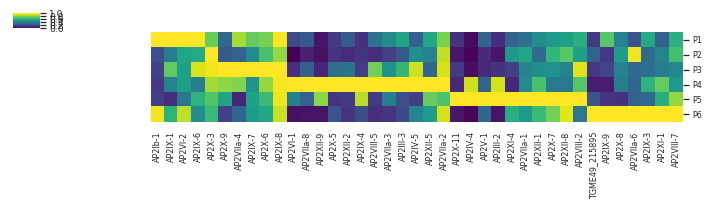

In [31]:
## Upregulated AP2
diff_genes = pd.read_csv(input_folder_dir+'stable4_pru_cluster_gene_assignment.tsv',
                         index_col=0, sep='\t')
diff_genes = diff_genes[diff_genes['adjusted-p'] < 0.01]
ap2 = [x for x, y in zip(diff_genes.index.values, diff_genes['product'].values)
       if 'AP2 domain' in y]

cluster_averaged = sat.average_by_clusters(np.log2(entire_df_pru[ap2]+1),
                                           return_clusters=True,
                                   clusters=adata_scv_pru.obs['louvain'].values)
cluster_averaged = cluster_averaged.div(cluster_averaged.max(axis=0), axis=1)
cluster_averaged.columns = [x.split(' ')[-1] if 'transcription' in x else y
                            for x, y in
                            zip(sat.get_product(cluster_averaged.columns,
                                           gpd),
                                cluster_averaged.columns.values)]

g = sns.clustermap(cluster_averaged, row_cluster=False, figsize=(12,2),
                  cmap='viridis', col_cluster=False)
g.ax_heatmap.tick_params(labelsize=8)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)
g.fig.savefig(output_dir+'fig3_AP2_clusters.pdf', bbox_inches='tight',
            transparent=True)

### Figure 3

SRS44 (CST1)
Enolase-2
SRS35A (SAG4)
LDH-2
saving figure to file /home/soso/GitRepositories/singleToxoplasmaSeq/Submission_analysis/Scripts/_loadlib/../../Figures/heatmap_fig3c_gene_rank.pdf


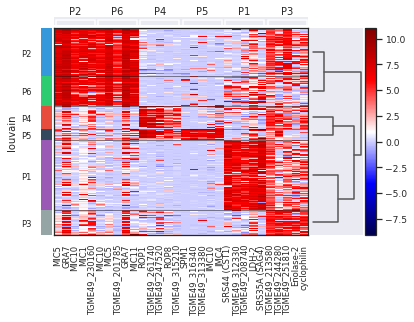

In [32]:
## Figure 3c gene clusters gene rank. AP2 gene clusters.
ad = adata_scv_pru.copy()
sc.pp.log1p(ad)
genes = ['TGME49_264660', 'TGME49_280570', 'TGME49_259020','TGME49_268860',
        'TGME49_291040', 'TGME49_233460', 'TGME49_268850', 'TGME49_232350']
titles = ['SRS44 (CST1)', 'SRS35A (SAG4)', 'BAG1', 'Enolase-1',
        'LDH-2', 'SRS29B (SAG1)', 'Enolase-2', 'LDH-1']
translate = {x:y for x, y in zip(genes, titles)}

sc.tl.rank_genes_groups(ad, groupby='louvain', method='wilcoxon', n_genes=5000)
res = ad.uns['rank_genes_groups']
top_10_genes = np.array(res['names'][:10].flatten())
all_names = []
for i in top_10_genes:
    for j in i:
        all_names.append(j)
all_names = np.array(all_names)
new_index = []
for i in ad.var.index.values:
    if i in all_names:
        product = sat.get_product(i, gpd)
        if i in translate.keys():
            new_index.append(translate[i])
            print(translate[i])
        elif 'hypothetical' not in product and len(i.split(' ')) == 1 and\
           'putative' not in product:
            split = product.split(' ')
            if split[-1] != 'protein':
                new_index.append(product.split(' ')[-1])
            else:
                new_index.append(product)
        else:
            new_index.append(i)
    else:
        new_index.append(i)
ad.var_names = new_index
sc.tl.rank_genes_groups(ad, groupby='louvain', method='wilcoxon', n_genes=5000)
sc.pl.rank_genes_groups_heatmap(ad, save='_fig3c_gene_rank.pdf', n_genes=5,
                                show_gene_labels=True, figsize=(6, 4),
                               cmap='seismic', vmax=11)

### Figure 3

Number of plots: 8


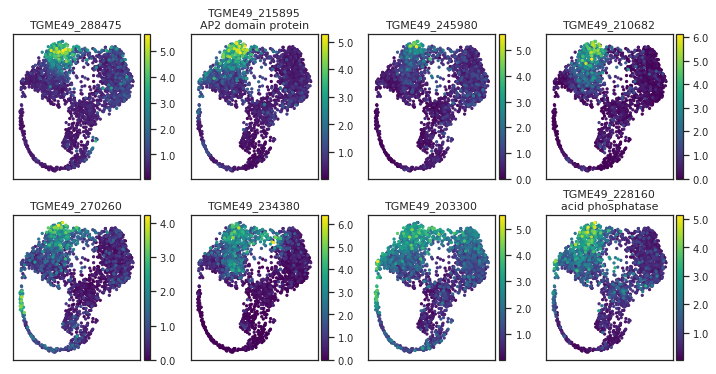

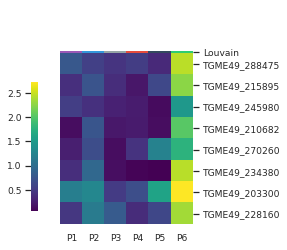

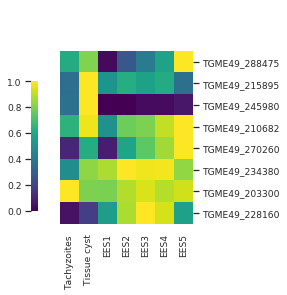

In [35]:
## Differential expression between clusters P2 and P6
## Find genes that are differentially expressed between the two
sc.tl.rank_genes_groups(adata_scv_pru, groupby='louvain')

threshold = 10**-3
cl = ['P6', 'P2']
subset = np.array([True if x in cl else False for x in
                   adata_scv_pru.obs['louvain'].values])
ad = adata_scv_pru[subset].copy()
sc.pp.log1p(ad)
X = pd.DataFrame(ad.X.A, columns=ad.var_names, index=ad.obs_names)
dtest = sat.analysis.dtest(X, ad.obs['louvain'].values,
                           cluster_of_interest='P6')
out1 = dtest.hypothesis_test()
out1['product'] = sat.get_product(out1.index, gpd)
out1 = out1.loc[out1['adjusted-p'] < threshold].sort_values('log2-fold',
                                                            ascending=False)
out1 = out1.loc[out1['log2-fold'] > 1]
cl = ['P6', 'P1']
subset = np.array([True if x in cl else False for x in
                   adata_scv_pru.obs['louvain'].values])
ad = adata_scv_pru[subset].copy()
sc.pp.log1p(ad)
X = pd.DataFrame(ad.X.A, columns=ad.var_names, index=ad.obs_names)
dtest = sat.analysis.dtest(X, ad.obs['louvain'].values,
                           cluster_of_interest='P6')
out2 = dtest.hypothesis_test()
out2['product'] = sat.get_product(out2.index, gpd)
out2 = out2.loc[out2['adjusted-p'] < threshold].sort_values('log2-fold',
                                                            ascending=False)
out2 = out2.loc[out2['log2-fold'] > 1]
genes = np.intersect1d(out1.index.values, out2.index.values)
fold = pd.DataFrame(np.array([out1.loc[genes, 'log2-fold'].values,
                            out2.loc[genes, 'log2-fold'].values]).T,
                   index=genes, columns=['out1', 'out2'])
fold['both'] = fold.min(axis=1)
fold = fold.sort_values('both', ascending=False)
g = fold.index.values[:8]

t = g.copy()
t[1] = g[1]+ '\nAP2 domain protein'
t[-1] = g[-1] + '\n' + sat.get_product(g[-1], gpd)
c = [np.log2(adata_allg_pru[:,x].X.astype(float)+1) for x in g]
adj = adata_scv_pru.uns['neighbors']['connectivities'].A
sat.plot.scatter(adata_scv_pru.obsm['X_umap'], c=c, s=5, figsize=(3, 3),
                        ncols=4, wspace=0.15, hspace=0.25, title=t, adj=adj,
                    filename=output_dir+'fig3_sfig6_P6_specific_genes_adj.pdf')
X = np.log2(entire_df_pru.copy()+1)
cat_X = pd.read_csv(input_folder_dir+'cat_all_RH.csv', index_col=0)
kerry_pru = pd.read_csv(input_folder_dir+'microarray_kerry_PRU.csv',
                        index_col=0)
cat_X.index = [x.split(' ')[0].replace('TGGT1_', 'TGME49_') for x in
               cat_X.index.values]
cat_X.columns = [x.replace('_', ' ') for x in cat_X.columns]
cat_norm = cat_X.div(cat_X.max(axis=1), axis=0)
cat_norm = cat_norm.fillna(0)
new_index = cat_norm.index.values
cat_norm.index = new_index

clusters_avg_p6 = sat.average_by_clusters(np.log2(entire_df_pru[g]+1),
                                          adata_scv_pru.obs['louvain'].values,
                                          return_clusters=True)
sat.plot.heatmap(clusters_avg_p6, row_cluster=False, col_cluster=False,
                 figsize=(3, 4), showxticks=True, showyticks=True,
                 col_colors=clusters_avg_p6.index.values,
                 col_cmap=louvain_cmap, cmap='viridis',
                 col_name='Louvain',
                 filename=output_dir+'fig3_P6_specific_genes.pdf')
sat.plot.heatmap(cat_norm.loc[g].T, row_cluster=False, col_cluster=False,
                 figsize=(3, 4), showxticks=True, showyticks=True,
                 col_cmap=louvain_cmap, cmap='viridis',
                 filename=output_dir+'fig3_cat_specific_genes.pdf');

### Figure 3 SFig 7
### Load scanorama results

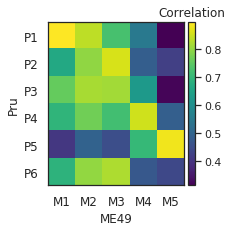

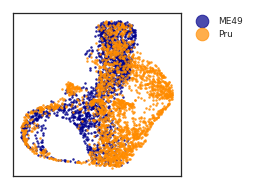

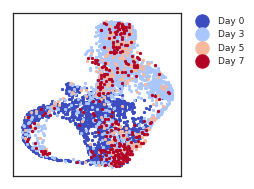

In [4]:
scv.settings.figdir = output_dir+'../Data/pru/'
sc.settings.figdir = output_dir+'../Data/pru/'
adatas = sc.read_h5ad(filename=output_dir+
                  '../Data/pru/adata_integrated_0506_me49.h5ad')
adata_scv_pru = sc.read_h5ad(output_dir+'../Data/pru/adata_sc_velocyto.h5ad')
adata_scv_me49 = sc.read_h5ad(output_dir+'../Data/011_me49/adata_sc_velocyto.h5ad')
## We are reloading log2 CPM values back to replace the merged expression matrix
adatas.X = sp.sparse.csr_matrix(np.log2(np.concatenate([adata_scv_me49.X.A,
                                         adata_scv_pru.X.A])+1))
del(adatas.uns['cell_cycle_colors'])
del(adata_scv_me49)
del(adata_scv_pru)
umap_merged_x = adatas.obsm['X_corrected_umap']
merged_x = adatas.obsm['X_corrected']
unique_labels = np.unique(adatas.obs['louvain'].values)
louvain_cdict = {x:y for x, y in zip(['M'+str(x) for x in range(1,6)], flatui)}
for x, y in zip(['P'+str(x) for x in range(1,7)], flatui):
    louvain_cdict[x] = y
gpd = {x:y for x,y in zip(adatas.var_names.values, adatas.var['product-0'].values)};


## calculate correlation
use_genes = adatas.var['used_for_projection-0'].values
use_genes = [True if x == 'True' else False for x in use_genes]
use_genes = adatas.var_names[use_genes]
df = pd.DataFrame(adatas.X.A, index=adatas.obs_names, columns=adatas.var_names)
df = df[use_genes]
avg_df = sat.average_by_clusters(df, clusters=adatas.obs['louvain'].values,
                                return_clusters=True)
corr = avg_df.T.corr()

unique_clusters = np.unique(adatas.obs['louvain'])
p_clusters = np.array([x for x in unique_clusters if 'P' in x])
m_clusters = np.array([x for x in unique_clusters if 'M' in x])
sub_corr = corr.loc[p_clusters, m_clusters]

## Pru to ME49 correlation heatmap
fig, ax = plt.subplots(figsize=(3, 3))
artist = ax.imshow(sub_corr, cmap='viridis')
divider = sat.plot.make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
ax.set_xticks(range(5))
ax.set_yticks(range(6))
ax.set_xticklabels(m_clusters)
ax.set_yticklabels(p_clusters)
ax.set_ylabel('Pru', fontsize=12)
ax.set_xlabel('ME49', fontsize=12)
ax.tick_params(labelsize=12)
ax.grid(False)
cbar = plt.colorbar(artist, cax=cax)
cbar.ax.set_title('Correlation', fontsize=12)
fig.savefig(output_dir+'fig3_sfig7b_merged_cluster_correlation.pdf', bbox_inches='tight')


plate_names = np.array([x.split('_')[1][5:8] for x in adatas.obs_names])
unique_plate_names = np.unique(plate_names)
cdict = {'Pru':'darkorange', 'ME49':'darkblue'}
order_cbar_labels = ['"G1 a"', '"G1 b"', '"S"', '"M"', '"C"']

sat.plot.scatter(umap_merged_x, c=adatas.obs['batch'], s=2.5, alpha=0.7,
                 cmap = cdict, filename=output_dir+'fig3_sfig7_merged_umap.pdf')
plot = sat.plot.scatter(umap_merged_x, c=adatas.obs['dpi'].values,
                        cmap='coolwarm', s=5, run=False)
fig, ax = plot.run()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
fig.savefig(output_dir+'fig3_sfig7_merged_umap_dpi.pdf', bbox_inches='tight',
            transparent=True)

### Figure 4

In [5]:
def calculate_ercc_values(entire_df_rc, entire_df, entire_df_07_rc):
    ercc_amount = sat.get_ercc_amount(which_mix='1', ercc_volume_added=100)
    ercc_amount_07 = sat.get_ercc_amount(which_mix='1', ercc_volume_added=8)
    ercc_det = (entire_df_rc[ercc_amount.index] > 1)
    ercc_det_freq = ercc_det.sum(axis=0) / np.shape(ercc_det)[0]
    ercc_det_var = entire_df[ercc_amount.index].var(axis=0)
    ercc_det_mean = entire_df[ercc_amount.index].mean(axis=0)
    ercc_det_var_log = np.log2(entire_df[ercc_amount.index]+1).var(axis=0)
    ercc_det_mean_log = np.log2(entire_df[ercc_amount.index]+1).mean(axis=0)
    avg_ercc_det = sat.average_by_clusters(pd.DataFrame(ercc_det_freq),
                           clusters=ercc_amount.values, return_clusters=True)
    ercc_cpm_nz = sat.calculate_vector_mean(np.log2(entire_df[
                            ercc_amount.index]+1), ignore_zeros=True, axis=0)
    avg_ercc_cpm_nz = sat.average_by_clusters(pd.DataFrame(ercc_cpm_nz),
                           clusters=ercc_amount.values, return_clusters=True) 
    ercc_det_freq_07 = (entire_df_07_rc[ercc_amount_07.index] > 1).sum(
                                    axis=0) / np.shape(entire_df_07_rc)[0]
    avg_ercc_det_07 = sat.average_by_clusters(pd.DataFrame(ercc_det_freq_07),
                       clusters=ercc_amount_07.values, return_clusters=True)
    return (ercc_amount, ercc_amount_07, ercc_det, ercc_det_freq, ercc_det_var, ercc_det_mean,
    ercc_det_var_log, ercc_det_mean_log, avg_ercc_det, ercc_cpm_nz, avg_ercc_cpm_nz,
    ercc_det_freq_07, avg_ercc_det_07)

adata_raw = sc.read_h5ad(input_folder_dir+'RH_96well_019/adata_raw.h5ad')
adata_allg = sc.read_h5ad(input_folder_dir+'RH_96well_019/adata_allg.h5ad')
entire_df = pd.DataFrame(adata_allg.X.A, index=adata_allg.obs_names, columns=adata_allg.var_names)
entire_df_rc = pd.DataFrame(adata_raw[adata_allg.obs_names][:, adata_allg.var_names].X.A,
                            index=adata_allg.obs_names, columns=adata_allg.var_names)
ad_cc_allg = sc.read_h5ad(input_folder_dir+'0701+0702/adata_allg.h5ad')
ad_cc_scv = sc.read_h5ad(input_folder_dir+'0701+0702/adata_sc_velocyto.h5ad')
g1_07_cells = ad_cc_allg.obs_names[ad_cc_allg.obs.cell_cycle == '"G1"']
ad_cc_raw = sc.read_h5ad(input_folder_dir+'0701+0702/adata_raw.h5ad')[g1_07_cells]
entire_df_07_rc = pd.DataFrame(ad_cc_raw.X.A, index=g1_07_cells, columns=ad_cc_raw.var_names)
binarized_entire_df_rc = (entire_df_rc > 1).copy()
gpd_rh = {x:y for x, y in zip(adata_raw.var_names, adata_raw.var['product'].values)}

(ercc_amount, ercc_amount_07, ercc_det, ercc_det_freq, ercc_det_var, ercc_det_mean,
ercc_det_var_log, ercc_det_mean_log, avg_ercc_det, ercc_cpm_nz, avg_ercc_cpm_nz, ercc_det_freq_07, avg_ercc_det_07) = calculate_ercc_values(entire_df_rc, entire_df, entire_df_07_rc)

### Figure 4 - Detection sensitivity

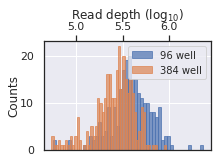

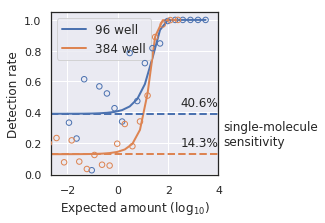

In [6]:
ercc_amount = sat.get_ercc_amount(which_mix='1', ercc_volume_added=100)
ercc_amount_07 = sat.get_ercc_amount(which_mix='1', ercc_volume_added=8)

mod96, sensitivity96 = sat.quantify_sensitivity(ercc_amount,
        entire_df_rc[ercc_amount.index], min_expression=1, s=50, figsize=(3, 3))
mod384, sensitivity384 = sat.quantify_sensitivity(ercc_amount_07,
        entire_df_07_rc[ercc_amount.index], min_expression=1, s=50, figsize=(3, 3))

x_96 = np.array(sorted(ercc_amount.values))
x_384 = np.array(sorted(ercc_amount_07.values))
y_96 = sat.logistic_model(x_96, mod96.coef_, mod96.intercept_).ravel()
y_384 = sat.logistic_model(x_384, mod384.coef_, mod384.intercept_).ravel()
ercc_ind_sorted_96 = ercc_amount.iloc[np.argsort(ercc_amount.values)]
ercc_ind_sorted_384 = ercc_amount_07.iloc[np.argsort(ercc_amount_07.values)]
sm_sensitivity_96 = sat.logistic_model([1], mod96.coef_, mod96.intercept_).ravel()[0]
sm_sensitivity_384 = sat.logistic_model([1], mod384.coef_, mod384.intercept_).ravel()[0]

fig, ax = plt.subplots(figsize=(3, 2))
ax.hist(np.log10(entire_df_rc.sum(axis=1)), edgecolor='C0',
        bins=50, alpha=0.7, label='96 well');
ax.hist(np.log10(entire_df_07_rc.sum(axis=1)), edgecolor='C1',
        bins=50, alpha=0.7, label='384 well');
ax.legend(fontsize=10);
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.set_xlabel(r'Read depth (log$_{10}$)', fontsize=12, labelpad=3);
ax.set_ylabel('Counts', fontsize=12, labelpad=0);
fig.savefig(output_dir+'fig4_read_counts_96well_384well.pdf', bbox_inches='tight')

fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(np.log10(sorted(ercc_amount)), y_96, lw=2, label='96 well', color='C0');
ax.plot(np.log10(sorted(ercc_amount_07)), y_384, lw=2, label='384 well', color='C1');
above_1 = avg_ercc_det.index >= 0.01
ax.scatter(np.log10(avg_ercc_det.index[above_1]), avg_ercc_det.values[above_1],
           s=30, edgecolor='C0', color='None', zorder=10);
ax.axhline(y_96.min(), ls='--', color='C0', lw=2);
ax.text(2.5, y_96.min()+0.05, str(round(sm_sensitivity_96*100, 1))+'%', ha='left', fontsize=12)
above_2 = avg_ercc_det_07.index >= 0.01
ax.scatter(np.log10(avg_ercc_det_07.index[above_1]), avg_ercc_det_07.values[above_1],
           s=30, edgecolor='C1', color='None', zorder=10);
ax.axhline(y_384.min(), ls='--', color='C1', lw=2);
ax.text(2.5, y_384.min()+0.05, str(round(sm_sensitivity_384*100, 1))+'%', ha='left', fontsize=12)
ax.text(4.2, (y_384.min()+y_96.min())/2, 'single-molecule\nsensitivity', fontsize=12, va='center')
ax.legend(fontsize=12, frameon=True);
ax.set_ylim(-0.01, 1.05);
ax.set_xlim(-2.65, );
ax.set_xlabel(r'Expected amount (log$_{10}$)');
ax.set_ylabel('Detection rate');
fig.savefig(output_dir+'fig4_single_molecule_sensitivity.pdf', bbox_inches='tight')

### Figure 4 - Calculating projection dependence

In [ ]:
## Projection dependence scores of cell cycle in RH
from analysis_scripts.cluster_dependence import knn_approach, get_gene_family

all_genes_dict = get_gene_family(gpd_rh, prefix='TGGT1_')

all_genes = ad_cc_scv.var_names.values
df_tmp = pd.DataFrame(ad_cc_scv.X.A , index=ad_cc_scv.obs_names,
        columns=ad_cc_scv.var_names)
weight = np.log2(df_tmp+1)
knn_cc = knn_approach(ad_cc_scv.obsm['X_pca'], weight, num=100,
                   metric='euclidean', k=5)
knn_cc.run(approach='knn', verbose=True)
df_dot_rh = knn_cc.df_scores.copy()
df_dot_rh.columns = ['Cell cycle']
df_dot_rh['Cell cycle'] /= df_dot_rh['Cell cycle'].max()

tmp_color_dict = {}
for key in all_genes_dict.keys():
    for value in all_genes_dict[key]:
        tmp_color_dict[value] = key
df_dot_rh_product = pd.DataFrame(sat.get_product(df_dot_rh.index.values,
                  gpd), index=df_dot.index, columns=['product'])
df_dot_rh_product['gene set'] = [tmp_color_dict[x] if x in tmp_color_dict.keys()
                              else 'Others' for x in
                              df_dot_rh_product.index.values]

## Projection dependence scores of cell cycle and asexual development in Pru
all_genes_dict = get_gene_family(gpd, prefix='TGME49_')

all_genes = adata_allg_pru.var_names.values
weight = np.log2(entire_df_pru[all_genes]+1)
knn_dev = knn_approach(adata_scv_pru.obsm['X_umap'], weight, num=100,
                       metric='euclidean', k=5)
knn_dev.run(approach='knn', verbose=True)
df_dot_pru = knn_dev.df_scores.copy()
df_dot_pru.columns = ['Development']
df_dot_pru['Development'] /= df_dot_pru['Development'].max()

subset = (adata_allg_pru.obs['dpi'] == 'Day 0').values
labels = adata_scv_pru.obs['cell_cycle'][subset]
# rh_adata = sc.read_h5ad(output_dir+'../0701+0702/adata_sc_velocyto.h5ad')
weight = pd.DataFrame(sat.cpm_normalize(adata_allg_pru[subset][:, all_genes].X.A),
                      index=adata_allg_pru.obs_names[subset], columns=all_genes)
weight = np.log2(weight + 1)
subset_genes = [True if x == 'True' else False for x in
                ad_cc_scv.var['used_for_projection'].values]
cell_cycle_genes = [x.replace('TGGT1_', 'TGME49_') for x in
        ad_cc_scv.var_names[subset_genes]]
cell_cycle_genes = np.intersect1d(cell_cycle_genes, adata_allg_pru.var_names)
day0_X = np.log2(sat.cpm_normalize(entire_df_pru.loc[subset, cell_cycle_genes]) + 1)
day0_pca = sklearn.decomposition.PCA(n_components=2).fit_transform(day0_X)
X = np.log2(sat.cpm_normalize(entire_df_pru.loc[subset, cell_cycle_genes]) + 1)
pca = sklearn.decomposition.PCA(n_components=2).fit_transform(X)

knn_cc = knn_approach(pca, weight, num=100, metric='euclidean', k=5)
knn_cc.run(approach='knn', verbose=True)
df_dot_pru['Cell cycle'] = knn_cc.df_scores.copy()
df_dot_pru['Cell cycle'] /= df_dot_pru['Cell cycle'].max()

tmp_color_dict = {}
for key in all_genes_dict.keys():
    for value in all_genes_dict[key]:
        tmp_color_dict[value] = key
df_dot_pru_product = pd.DataFrame(sat.get_product(df_dot_pru.index.values,
                  gpd), index=df_dot_pru.index, columns=['product'])
df_dot_pru_product['gene set'] = [tmp_color_dict[x] if x in tmp_color_dict.keys()
                              else 'not_in_product' for x in
                              df_dot_pru_product.index.values]